In [4]:
import os
import wandb
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import netCDF4 as nc

import lightning as L

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm
import scipy
from scipy import ndimage

import pandas as pd


import sys
sys.path.append('../')

#Models
from models.swin_fir.swin_fir import SwinFIR, SwinFIR_sidechannel
from models.interpolation_models import InterpolationModel

#Data

from dataset_utils.ERA2CERRA import ERA2CERRA_Dataset
from dataset_utils.ERA_dataset import ERA_Dataset
from dataset_utils.LightningDataModules import Era2CerraDataModule, EraDataModule

In [5]:
device = torch.device('cpu')

## Examples of how to use the model and dataset (and generate the Figures from the Paper):

In [6]:
# Load the model
model = SwinFIR_sidechannel.load_from_checkpoint("../artifacts/wj8yuabe:v8/model.ckpt")
channel_names = model.hparams.channel_names
print("Channel names: ", channel_names)


# Load the Dataset
datamodule = Era2CerraDataModule("../data", downscaling_factor=model.hparams.upscale, num_workers=0, batch_size=10, crop_size=model.hparams.img_size * model.hparams.upscale, channel_names=model.hparams.channel_names, constant_channels = True, return_era_original=True, cropping='deterministic', return_offset=True, test_years=[2020,2020], use_separate_dataset=True)

datamodule.setup('test')
dataloader = datamodule.test_dataloader()
dataset = dataloader.dataset


/opt/homebrew/anaconda3/envs/climate/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Dataset metrics provided. Using provided values.
Channel names:  ['u10', 'v10', 't2m', 'sp', 'msl', 't850', 'u1000', 'v1000', 'z1000', 'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv']
Loading Era2Cerra DataModule 

Loaded Mean/Std from file
Using ERA5 and CERRA dataset with separate u10/v10
Return dataset in custom mode. Years [2020]
Number of Files 1
Loaded Mean/Std from file
Dataset running in deterministic cropping mode. Number of crops per sample: 16. Total length: 3840
Loaded constant data from file


In [7]:
def upsample(input, downscaling_factor=4):
    # Upsample the output to the size of the input
    upsampled_output = F.interpolate(input.unsqueeze(0), scale_factor=downscaling_factor, mode='bicubic', align_corners=False)
    return upsampled_output


def predict(data):
    model.eval()

    era_original = None

   
    lr = data[0][0]
    hr = data[1][0]
    const_data = data[1][1]

    with torch.no_grad():
        input = lr.to(device)
        input_const = const_data.to(device)

        output = model((input.unsqueeze(0), input_const.unsqueeze(0)))
        output = output[0]


    input = input.cpu()
    output = output.cpu()  

    upsample_output = upsample(lr, model.hparams.upscale)


    # hr = hr.unsqueeze(0)
    input = input * dataset.variable_std + dataset.variable_mean
    hr = hr.unsqueeze(0) * dataset.variable_std + dataset.variable_mean
    output = output * dataset.variable_std + dataset.variable_mean
    upsample_output = upsample_output * dataset.variable_std + dataset.variable_mean

    if era_original is not None:
        era_original = era_original * dataset.variable_std + dataset.variable_mean

    return [input, output, upsample_output, hr, era_original]

In [8]:
random_idx = 0 + torch.randint(0, len(dataset)//16, (1,)).item() * 16
print(random_idx)

#Get a random timestep

patch_size_lr = model.hparams.img_size
patch_size_hr = model.hparams.img_size * model.hparams.upscale

global_input = torch.empty((20,256,256))
global_output = torch.empty((20,1024,1024))
global_upsample_output = torch.empty((20,1024,1024))
global_hr = torch.empty((20,1024,1024))

#Generate the high-res version for the entire EuroCordex Domain
for i in range(16):
    data = dataset[random_idx + i]
    input, output, upsample_output, hr, era_original = predict(data)

    global_input[:, data[2][0]//model.hparams.upscale :data[2][0]//model.hparams.upscale+patch_size_lr, data[2][1]//model.hparams.upscale:data[2][1]//model.hparams.upscale+patch_size_lr] = input.squeeze()
    global_output[:, data[2][0]:data[2][0]+patch_size_hr , data[2][1]:data[2][1]+patch_size_hr] = output.squeeze()
    global_upsample_output[:, data[2][0]:data[2][0]+patch_size_hr, data[2][1]:data[2][1]+patch_size_hr] = upsample_output.squeeze()
    global_hr[:, data[2][0]:data[2][0]+patch_size_hr, data[2][1]:data[2][1]+patch_size_hr] = hr.squeeze()

224


### Generating Figure 4

t2m


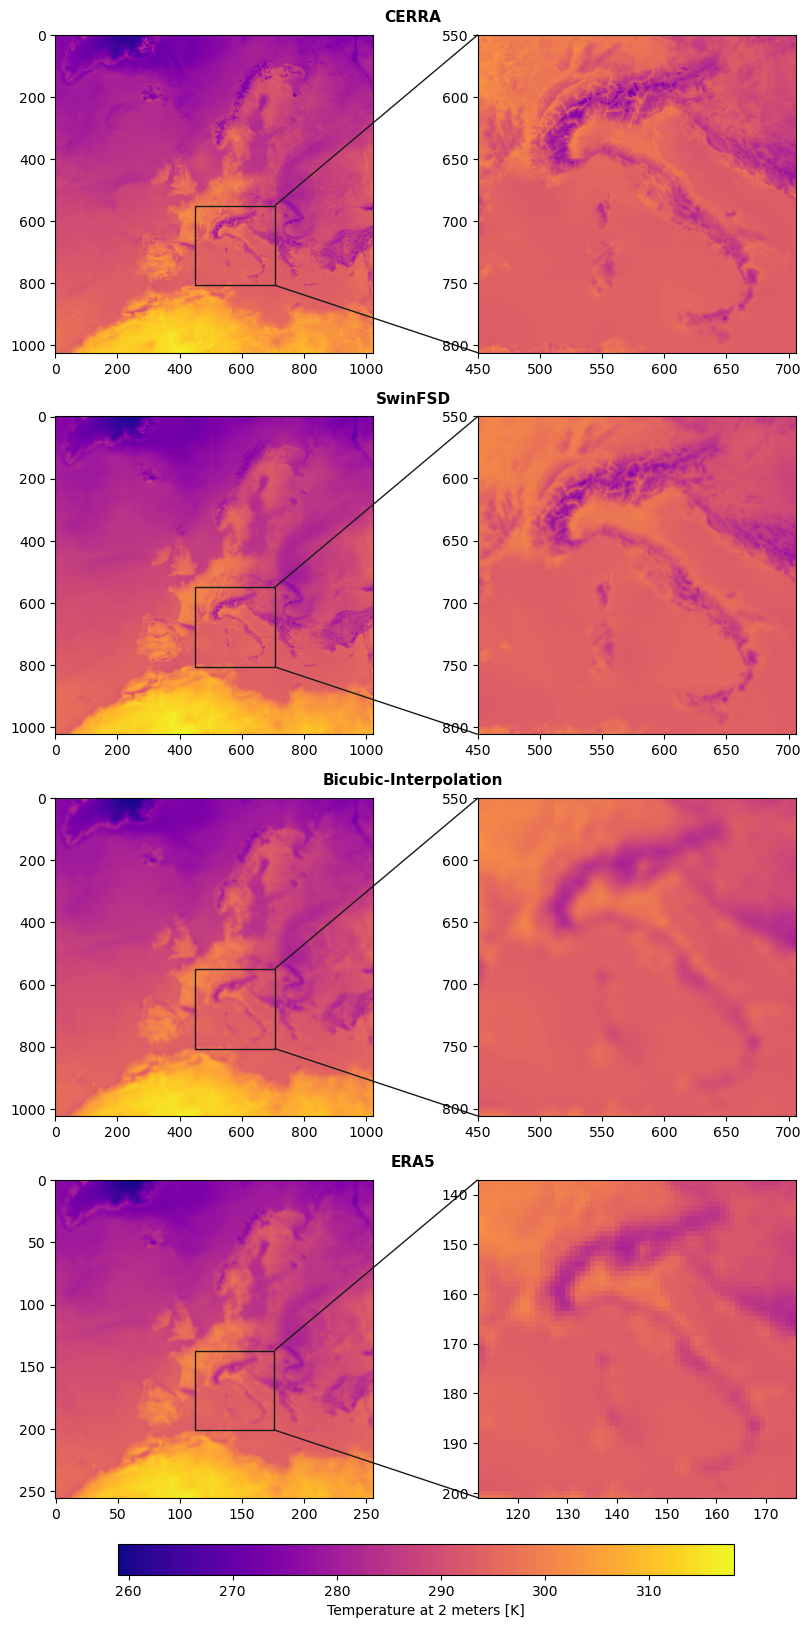

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
import numpy as np

def mark_inset_mod(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2


fig, axes = plt.subplots(4, 2, figsize=(10, 20))

sel_channel = 2 #19
print(channel_names[sel_channel])
zoom_x, zoom_y = (450, 550)
zoom_size = 256

cmap = 'plasma'
vmin = min(global_hr[sel_channel].min(), global_output[sel_channel].min(), global_upsample_output[sel_channel].min(), global_input[sel_channel].min())
vmax = max(global_hr[sel_channel].max(), global_output[sel_channel].max(), global_upsample_output[sel_channel].max(), global_input[sel_channel].max())

# Iterate over each subplot and set a title

pos = axes[0,0].get_position()  # Get the position of the axes in figure coordinates
fig.text(0.5, pos.y1 + 0.005, "CERRA", ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0, 0].imshow(global_hr[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)

# Add side-by-side inset
inset_ax = axes[0,1]
inset_ax.imshow(global_hr[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)
inset_ax.set_xlim(zoom_x, zoom_x + zoom_size)
inset_ax.set_ylim(zoom_y + zoom_size, zoom_y)

# Optional: Draw a connecting line between the plots
mark_inset_mod(axes[0,0], inset_ax, loc1a=2, loc2a=3, loc1b=4, loc2b=1, fc="none", ec="0.1")

# axes[1, 0].set_title('ML-Reconstruction')
pos = axes[1,0].get_position()  # Get the position of the axes in figure coordinates
fig.text(0.5, pos.y1 + 0.015, "SwinFSD", ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 0].imshow(global_output[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)

# Add side-by-side inset
inset_ax = axes[1,1]
inset_ax.imshow(global_output[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)
inset_ax.set_xlim(zoom_x, zoom_x + zoom_size)
inset_ax.set_ylim(zoom_y + zoom_size, zoom_y)

# Optional: Draw a connecting line between the plots
mark_inset_mod(axes[1,0], inset_ax, loc1a=2, loc2a=3, loc1b=4, loc2b=1, fc="none", ec="0.1")

# axes[2, 0].set_title('Bicubic-Interpolation')
pos = axes[2,0].get_position()  # Get the position of the axes in figure coordinates
fig.text(0.5, pos.y1 + 0.025, "Bicubic-Interpolation", ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[2, 0].imshow(global_upsample_output[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)

# Add side-by-side inset
inset_ax = axes[2,1]
inset_ax.imshow(global_upsample_output[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)
inset_ax.set_xlim(zoom_x, zoom_x + zoom_size)
inset_ax.set_ylim(zoom_y + zoom_size, zoom_y)

# Optional: Draw a connecting line between the plots
mark_inset_mod(axes[2,0], inset_ax, loc1a=2, loc2a=3, loc1b=4, loc2b=1, fc="none", ec="0.1")

# axes[3, 0].set_title('ERA5')
pos = axes[3,0].get_position()  # Get the position of the axes in figure coordinates
fig.text(0.5, pos.y1 + 0.035, "ERA5", ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[3, 0].imshow(global_input[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)

# Add side-by-side inset
inset_ax = axes[3,1]
inset_ax.imshow(global_input[sel_channel], cmap=cmap, vmin=vmin, vmax=vmax)
inset_ax.set_xlim(zoom_x//4, zoom_x//4 + zoom_size//4)
inset_ax.set_ylim(zoom_y//4 + zoom_size//4, zoom_y//4)

# Optional: Draw a connecting line between the plots
mark_inset_mod(axes[3,0], inset_ax, loc1a=2, loc2a=3, loc1b=4, loc2b=1, fc="none", ec="0.1")

cbar = fig.colorbar(axes[0, 0].images[0], ax=axes, orientation='horizontal', fraction=0.02, pad=0.03)
cbar.ax.set_xlabel('Temperature at 2 meters [K]', rotation=0)

#plt.savefig('artifacts/output_visual.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Generating Figure 5 (Channel Importance)

In [10]:
data_path = '../artifacts/xai/integrated_gradients.csv'

df = pd.read_csv(data_path)
df = df[['Name', 'names', 'relevance', 'names_side', 'relevance_side']]


df['relevance'] = df['relevance'].apply(lambda x: (x.replace('[', '').replace(']', '').split(',')))
df['relevance'] = df['relevance'].apply(lambda x: [float(i) for i in x])
df['relevance_side'] = df['relevance_side'].apply(lambda x: (x.replace('[', '').replace(']', '').split(',')))
df['relevance_side'] = df['relevance_side'].apply(lambda x: [float(i) for i in x])
df['names'] = df['names'].apply(lambda x: (x.replace('[', '').replace(']', '').replace('"', '').split(',')))
df['names_side'] = df['names_side'].apply(lambda x: (x.replace('[', '').replace(']', '').replace('"', '').split(',')))
df['relevance_combined'] = df.apply(lambda x: (x['relevance']) + (x['relevance_side']), axis=1)
df['relevance_combined'] = df['relevance_combined'].apply(lambda x: [i / sum(x) for i in x])
df['names_combined'] = df.apply(lambda x: x['names'] + x['names_side'], axis=1)


plot_df = df.explode(['relevance_combined', 'names_combined'])[['Name', 'relevance_combined', 'names_combined']]
name_conversion = {'xai': 'All channels (0.015)', 'xai-noSp': 'SP removed (0.016)', 'xai-noSpT2M': 'SP and T2M removed (0.015)'}
name_order = ['xai', 'xai-noSp', 'xai-noSpT2M']

plot_df = plot_df.sort_values(by='Name', key=lambda x: x.map(name_order.index))

plot_df['Name'] = plot_df['Name'].apply(lambda x: name_conversion[x])

channel_names = [ 'u10', 'v10', 't2m', 'sp', 'msl', 't850', 'u1000', 'v1000', 'z1000', 'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv', 'land-sea mask', 'orography']


fig = px.bar(plot_df, x='names_combined', y='relevance_combined', color='Name', barmode='group', labels={'names_combined': 'Input-Variable', 'relevance_combined': 'Relevance', 'Name': ''}, width=800, height=400)

# choose the figure font
font_dict=dict(family='Serif', size=12, color='black')

# general figure formatting
fig.update_layout(font=font_dict,  # font formatting
                  plot_bgcolor='white',  # background color
                  yaxis=dict(showgrid=True, gridcolor='lightgray'),  # add horizontal grid lines
                  margin=dict(r=10,t=10,b=10)  # remove white space 
                  )

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.update_xaxes(categoryorder='array', categoryarray= channel_names)
fig.update_xaxes(tickangle=45)


fig.show()
# pio.write_image(fig, "../artifacts/IG-comparison.pdf", width=3*300, height=1.5*300)

### Generating Figure 6 (Spatial Importance)

In [11]:
xai_datamodule = Era2CerraDataModule("../data", downscaling_factor=model.hparams.upscale, num_workers=0, batch_size=10, crop_size=model.hparams.img_size * model.hparams.upscale, channel_names=model.hparams.channel_names, constant_channels = True, return_era_original=True, cropping='germany', test_years=(2020,2020), use_separate_dataset=True)
xai_datamodule.setup('test')
xai_dataset = xai_datamodule.test_dataloader().dataset

data = xai_dataset[0]

Loading Era2Cerra DataModule 

Loaded Mean/Std from file
Using ERA5 and CERRA dataset with separate u10/v10
Return dataset in custom mode. Years [2020]
Number of Files 1
Loaded Mean/Std from file
Returns only a patch centered on Germany
Loaded constant data from file


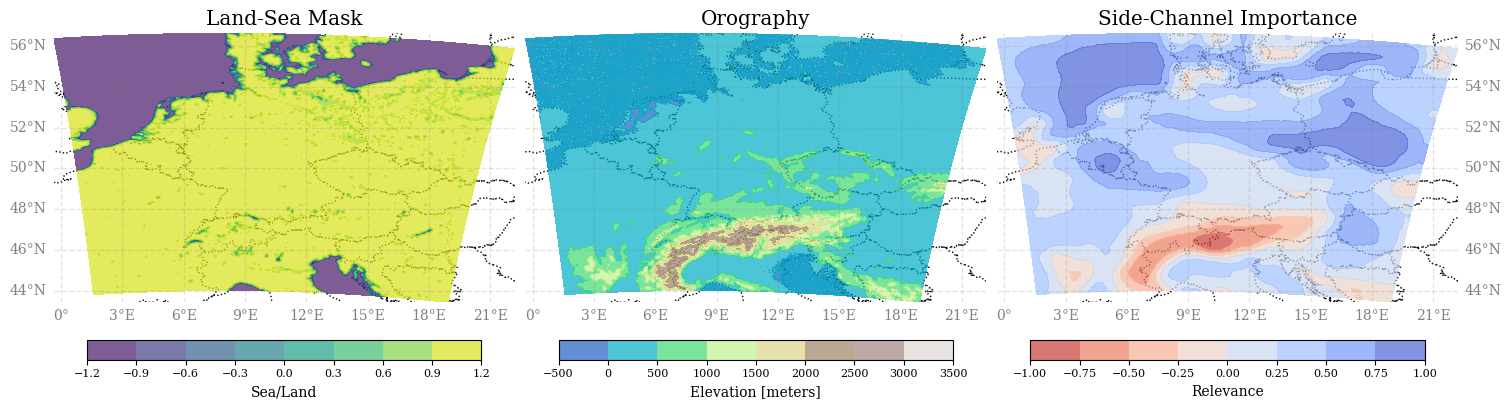

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

text_width = 411.93877
def set_size(width, fraction=1):
    #Set figure dimensions to avoid scaling in LaTeX.

    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

y_pos = 400
x_pos = 440

plt.rcParams.update(tex_fonts)
fig, ax = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)

lats, lons = torch.load('../data/CERRA/preprocessed_separate/lat_lon_const.pt', map_location='cpu', weights_only=True)
lats = lats[y_pos:y_pos + 256, x_pos:x_pos + 256]
lons = lons[y_pos:y_pos + 256, x_pos:x_pos + 256]

side_attributions = np.load('../artifacts/xai/attribution_side.npy')

side_attributions = side_attributions / side_attributions.sum()
side_attributions = abs(side_attributions) * 100
comparison = side_attributions[0] - side_attributions[1]
comparison = scipy.ndimage.uniform_filter(comparison, size=16)
comparison = 2 * (comparison - np.min(comparison)) / (np.max(comparison) - np.min(comparison)) - 1


orography = data[1][1][1].detach().cpu().numpy()


orography = (orography * 444.1848) + 236.8313

projection = ccrs.PlateCarree()

# Remove overlapping axes explicitly
for ax in fig.axes:
	ax.remove()


ax1 = plt.subplot(1, 3, 1, projection=projection)
ax1.add_feature(cfeature.COASTLINE, linestyle=":")
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_title('Land-Sea Mask')
ax1.axis('off')
cbar1 = fig.colorbar(ax1.contourf(lons, lats, data[1][1][0].detach().cpu().numpy(), cmap='viridis', transform=projection, alpha=0.7, zorder=2), ax=ax1, orientation='horizontal', fraction=0.05, pad=0.04)
cbar1.ax.set_xlabel('Sea/Land', rotation=0)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = gl.xlabel_style.copy()


ax2 = plt.subplot(1, 3, 2, projection=projection)
ax2.add_feature(cfeature.COASTLINE, linestyle=":")
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_title('Orography')
ax2.axis('off')
cbar2 = fig.colorbar(ax2.contourf(lons, lats, orography, cmap='terrain', transform=projection, alpha=0.7, zorder=2), ax=ax2, orientation='horizontal', fraction=0.05, pad=0.04)
cbar2.ax.set_xlabel('Elevation [meters]', rotation=0)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = gl.xlabel_style.copy()


ax3 = plt.subplot(1, 3, 3, projection=projection)
ax3.add_feature(cfeature.COASTLINE, linestyle=":")
ax3.add_feature(cfeature.BORDERS, linestyle=':',)
ax3.set_title('Side-Channel Importance')
ax3.axis('off')
cbar3 = fig.colorbar(ax3.contourf(lons, lats, comparison, cmap='coolwarm_r', transform=projection, alpha=0.7, zorder=2), ax=ax3, orientation='horizontal', fraction=0.05, pad=0.04)
cbar3.ax.set_xlabel('Relevance', rotation=0)

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = gl.xlabel_style.copy()

plt.savefig('../artifacts/IG-sidechannels.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Generating Figure 2 (Data Extent)

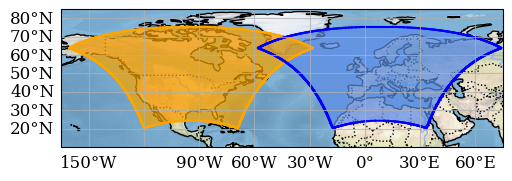

In [14]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_both():
    lat_a, lon_a = torch.load('../data/ERA5/america_preprocessed_separate/america_lat_lon.pt', weights_only=True)
    lat_e, lon_e = torch.load('../data/CERRA/preprocessed_separate/lat_lon_const.pt', weights_only=True)

    # Plot the grid on a map
    fig, ax = plt.subplots(figsize=set_size(text_width), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-165, 75, 10, 85], crs=ccrs.PlateCarree())  # Set the extent to cover North America

    # Add geographic features
    ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Add gridlines with coordinate markings
    gl = ax.gridlines(draw_labels=True, alpha=0.75)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    decimal_digits = 1
    lat_e, lon_e = lat_e.numpy(), lon_e.numpy()
    lat_e, lon_e = np.around(lat_e, decimal_digits), np.around(lon_e, decimal_digits)

    lat_a, lon_a = lat_a.numpy(), lon_a.numpy()
    lat_a, lon_a = np.around(lat_a, decimal_digits), np.around(lon_a, decimal_digits)


    unique_min_e = {}
    unique_max_e = {}

    #get_point of concave section in the south

    cutoff_e = lat_e[-1].max()
    cutoff_a = lat_a[-1].max()


    for i in range(lat_e.shape[0]):
        for j in range(lat_e.shape[1]):

            key = lat_e[i, j]

            if key < cutoff_e:
                if j >= lat_e.shape[1]/2:
                   key = lat_e[i, j] + 0.0001


            if key not in unique_min_e:
                unique_min_e[key] = lon_e[i, j]
                unique_max_e[key] = lon_e[i, j]
            else:
                unique_min_e[key] = min(unique_min_e[key], lon_e[i, j])
                unique_max_e[key] = max(unique_max_e[key], lon_e[i, j])

    unique_min_a = {}
    unique_max_a = {}

    for i in range(lat_a.shape[0]):
        for j in range(lat_a.shape[1]):

            key = lat_a[i, j]

            if key < cutoff_a:
                if j >= lat_a.shape[1]/2:
                   key = lat_a[i, j] + 0.001


            if key not in unique_min_a:
                unique_min_a[key] = lon_a[i, j]
                unique_max_a[key] = lon_a[i, j]
            else:
                unique_min_a[key] = min(unique_min_a[key], lon_a[i, j])
                unique_max_a[key] = max(unique_max_a[key], lon_a[i, j])
            

    for lat in unique_min_e:
        ax.plot([unique_min_e[lat], unique_max_e[lat]], [lat, lat], color='cornflowerblue', transform=ccrs.PlateCarree(), alpha=0.1)

    for lat in unique_min_a:
        ax.plot([unique_min_a[lat], unique_max_a[lat]], [lat, lat], color='orange', transform=ccrs.PlateCarree(), alpha=0.1)

    first = True    
    lats = np.array(list(unique_min_a.keys()))
    for i in range(0, len(lats)-2):

        if abs(lats[i] - lats[i+1]) > 1:
            ax.plot([unique_min_a[lats[i]], unique_max_a[lats[i]]], [lats[i], lats[i]], color='orange', transform=ccrs.PlateCarree(), alpha=1)
            continue

        if abs(unique_min_a[lats[i]] - unique_min_a[lats[i+1]]) > 5:
            if first:
                ax.plot([unique_max_a[lats[i]], unique_min_a[lats[i+1]]], [lats[i], lats[i+1]], color='orange', transform=ccrs.PlateCarree(), alpha=1)
                first = False

            # print(lats[i], lats[i+2], unique_min_a[lats[i]], unique_min_a[lats[i+2]])
            ax.plot([unique_min_a[lats[i]], unique_min_a[lats[i+2]]], [lats[i], lats[i+2]], color='orange', transform=ccrs.PlateCarree(), alpha=1)
            
            # print(lats[i], lats[i+2], unique_min_a[lats[i]], unique_min_a[lats[i+2]])
            ax.plot([unique_max_a[lats[i]], unique_max_a[lats[i+2]]], [lats[i], lats[i+2]], color='orange', transform=ccrs.PlateCarree(), alpha=1)
            continue

        elif abs(unique_max_a[lats[i]] - unique_max_a[lats[i+1]]) > 5:
            continue

        ax.plot([unique_min_a[lats[i]], unique_min_a[lats[i+1]]], [lats[i], lats[i+1]], color='orange', transform=ccrs.PlateCarree(), alpha=1)
        ax.plot([unique_max_a[lats[i]], unique_max_a[lats[i+1]]], [lats[i], lats[i+1]], color='orange', transform=ccrs.PlateCarree(), alpha=1)

    first = True    
    lats = np.array(list(unique_min_e.keys()))
    for i in range(0, len(lats)-2):

        if abs(lats[i] - lats[i+1]) > 1:
            ax.plot([unique_min_e[lats[i]], unique_max_e[lats[i]]], [lats[i], lats[i]], color='blue', transform=ccrs.PlateCarree(), alpha=1)
            continue

        if abs(unique_min_e[lats[i]] - unique_min_e[lats[i+1]]) > 5:
            if first:
                ax.plot([unique_max_e[lats[i]], unique_min_e[lats[i+1]]], [lats[i], lats[i+1]], color='blue', transform=ccrs.PlateCarree(), alpha=1)
                first = False

            # print(lats[i], lats[i+2], unique_min_e[lats[i]], unique_min_e[lats[i+2]])
            ax.plot([unique_min_e[lats[i]], unique_min_e[lats[i+2]]], [lats[i], lats[i+2]], color='blue', transform=ccrs.PlateCarree(), alpha=1)
            
            # print(lats[i], lats[i+2], unique_min_e[lats[i]], unique_min_e[lats[i+2]])
            ax.plot([unique_max_e[lats[i]], unique_max_e[lats[i+2]]], [lats[i], lats[i+2]], color='blue', transform=ccrs.PlateCarree(), alpha=1)
            continue

        elif abs(unique_max_e[lats[i]] - unique_max_e[lats[i+1]]) > 5:
            continue

        ax.plot([unique_min_e[lats[i]], unique_min_e[lats[i+1]]], [lats[i], lats[i+1]], color='blue', transform=ccrs.PlateCarree(), alpha=1)
        ax.plot([unique_max_e[lats[i]], unique_max_e[lats[i+1]]], [lats[i], lats[i+1]], color='blue', transform=ccrs.PlateCarree(), alpha=1)

    # Save the plot as a PDF
    # plt.savefig('../artifacts/plots/grid_coverage_both.pdf', bbox_inches='tight')
    plt.show()

plot_both()

## Generating the Tables from W&B Data

In [15]:
#TABLE 1

columns = ['Name','test_loss', 'test_psnr_cyclic', 'test_mse']
data_path = '../artifacts/paper_data/paper_europe.csv'
order = [ 'Bicubic-Interpolation', 'EDSR', 'EDSR-side', 'SwinFIR', 'SwinFIR-side']

difference = False

name_conversion = {
                'era2cerra-4x-noside': 'SwinFIR',
                'era2cerra-4x': 'SwinFIR-side',
                'EDSR-era2cerra': 'EDSR-side',
                'EDSR-era2cerra-noside': 'EDSR',
                'era2cerra-interpolation-1x': 'Bicubic-Interpolation',
                'cerra-passthrough': 'CERRA'}

columns_conversion = {'Name': 'Model', 'test_loss': 'Loss', 'test_psnr_cyclic': 'PSNR', 'test_mse': 'MSE'}


df = pd.read_csv(data_path)


df = df[columns]
df['Name'] = df['Name'].apply(lambda x: name_conversion[x])
df = df.set_index('Name').reindex(order).reset_index()



if difference:
    df['test_loss'] = df['test_loss'].apply(lambda x: f"{x:.4f}")
    df['test_psnr_cyclic'] = df['test_psnr_cyclic'].apply(lambda x: f"{x:.2f}")
    df['test_mse'] = df['test_mse'].apply(lambda x: f"{x:.2f}")

    comparison = df.iloc[3]

    df['Loss-Difference'] = df['test_loss'].apply(lambda x: f" ({(float(x) - float(comparison['test_loss'])) / float(comparison['test_loss']) * 100 :+3.1f}%)")
    df['PSNR-Difference'] = df['test_psnr_cyclic'].apply(lambda x: f" ({(float(x) - float(comparison['test_psnr_cyclic'])) / float(comparison['test_psnr_cyclic']) * 100 :+2.1f}%)")
    df['MSE-Difference'] = df['test_mse'].apply(lambda x: f" ({(float(x) - float(comparison['test_mse'])) / float(comparison['test_mse']) * 100 :+3.1f}%)")

df = df.rename(columns=columns_conversion)

if difference:
    df['MSE-S'] = df['Loss'] + df['Loss-Difference']
    df['PSNR'] = df['PSNR'] + df['PSNR-Difference']
    df['MSE'] = df['MSE'] + df['MSE-Difference']
    df = df[['Model', 'MSE-S', 'PSNR', 'MSE']]
else:
    df['RMSE-S'] = df['Loss'].apply(lambda x: f"{np.sqrt(x):.4f}")
    df['PSNR'] = df['PSNR'].apply(lambda x: f"{x:.2f}")
    df['RMSE'] =  df['MSE'].apply(lambda x: f"{np.sqrt(x):.2f}")
    df = df[['Model', 'RMSE-S', 'PSNR', 'RMSE']]

print(df.to_latex(index=False, escape=True, caption='Caption'))

\begin{table}
\centering
\caption{Caption}
\begin{tabular}{llll}
\toprule
                Model & RMSE-S &  PSNR &   RMSE \\
\midrule
Bicubic-Interpolation & 0.2820 & 32.56 & 180.62 \\
                 EDSR & 0.1497 & 37.99 &  44.55 \\
            EDSR-side & 0.1451 & 38.26 &  51.53 \\
              SwinFIR & 0.1412 & 38.50 &  47.18 \\
         SwinFIR-side & 0.1414 & 38.48 &  37.95 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/xj/cbm5zytd4tb28hsqgk8cbt4c0000gn/T/ipykernel_74380/3740279558.py:53: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [16]:
#TABLE 2

columns = ['Name','mse_si10', 'mse_t2m', 'mse_sp', 'mse_msl', 'mse_tcwv', 'mse_z500']
data_path = '../artifacts/paper_data/paper_europe.csv'
order = [ 'Bicubic-Interpolation', 'EDSR', 'EDSR-side', 'SwinFIR', 'SwinFIR-side']
RMSE = True
denormalize = True

name_conversion = {
                'era2cerra-4x-noside': 'SwinFIR',
                'era2cerra-4x': 'SwinFIR-side',
                'EDSR-era2cerra': 'EDSR-side',
                'EDSR-era2cerra-noside': 'EDSR',
                'era2cerra-interpolation-1x': 'Bicubic-Interpolation',
                'cerra-passthrough': 'CERRA'}

columns_conversion = {'Name': 'Model', 'mse_si10': 'Si10', 'mse_t2m': 'T2M', 'mse_sp': 'SP', 'mse_tcwv': 'TCWV', 'mse_msl': 'MSLP', 'mse_z500': 'Z500'}

df = pd.read_csv(data_path)
df = df[columns]
df['Name'] = df['Name'].apply(lambda x: name_conversion[x])
df = df.set_index('Name').reindex(order).reset_index()

if denormalize:
    df['mse_si10'] = df['mse_si10'].apply(lambda x: x * 3.695860737416358)
    df['mse_t2m'] = df['mse_t2m'].apply(lambda x: x * 10.052838398795886)
    df['mse_sp'] = df['mse_sp'].apply(lambda x: x * 5012.476996727906)
    df['mse_tcwv'] = df['mse_tcwv'].apply(lambda x: x * 6.523883304581078)
    df['mse_msl'] = df['mse_msl'].apply(lambda x: x * 942.5295226976508)
    df['mse_z500'] = df['mse_z500'].apply(lambda x: x * 1912.32740113131)


if RMSE:
    df['mse_si10'] = df['mse_si10'].apply(lambda x: np.sqrt(x))
    df['mse_t2m'] = df['mse_t2m'].apply(lambda x: np.sqrt(x))
    df['mse_sp'] = df['mse_sp'].apply(lambda x: np.sqrt(x))
    df['mse_tcwv'] = df['mse_tcwv'].apply(lambda x: np.sqrt(x))
    df['mse_msl'] = df['mse_msl'].apply(lambda x: np.sqrt(x))
    df['mse_z500'] = df['mse_z500'].apply(lambda x: np.sqrt(x))


comparison = df.iloc[3]


df['Si10-diff'] = df['mse_si10'].apply(lambda x: f" ({(float(x) - float(comparison['mse_si10'])) / float(comparison['mse_si10']) * 100 :+02.2f}%)")
df['T2M-diff'] = df['mse_t2m'].apply(lambda x: f" ({(float(x) - float(comparison['mse_t2m'])) / float(comparison['mse_t2m']) * 100 :+02.2f}%)")
df['SP-diff'] = df['mse_sp'].apply(lambda x: f" ({(float(x) - float(comparison['mse_sp'])) / float(comparison['mse_sp']) * 100 :+02.2f}%)")
df['MSLP-diff'] = df['mse_msl'].apply(lambda x: f" ({(float(x) - float(comparison['mse_msl'])) / float(comparison['mse_msl']) * 100 :+02.2f}%)")
df['TCWV-diff'] = df['mse_tcwv'].apply(lambda x: f" ({(float(x) - float(comparison['mse_tcwv'])) / float(comparison['mse_tcwv']) * 100 :+02.2f}%)")
df['Z500-diff'] = df['mse_z500'].apply(lambda x: f" ({(float(x) - float(comparison['mse_z500'])) / float(comparison['mse_z500']) * 100 :+02.2f}%)")


df = df.rename(columns=columns_conversion)


df = df[['Model', 'Si10', 'T2M', 'SP', 'MSLP', 'TCWV', 'Z500']]

print(df.to_latex(index=False, escape=True, caption='Caption', float_format="%.4f"))

\begin{table}
\centering
\caption{Caption}
\begin{tabular}{lrrrrrr}
\toprule
                Model &   Si10 &    T2M &      SP &   MSLP &   TCWV &   Z500 \\
\midrule
Bicubic-Interpolation & 0.6469 & 0.4438 & 11.3109 & 1.8504 & 0.3689 & 1.1062 \\
                 EDSR & 0.4981 & 0.3157 &  2.2548 & 1.7176 & 0.3240 & 1.2992 \\
            EDSR-side & 0.4878 & 0.3002 &  2.8436 & 1.7453 & 0.3165 & 1.2285 \\
              SwinFIR & 0.4714 & 0.2819 &  2.6154 & 1.6112 & 0.3107 & 1.0932 \\
         SwinFIR-side & 0.4693 & 0.2780 &  1.8674 & 1.6173 & 0.3091 & 1.1345 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/xj/cbm5zytd4tb28hsqgk8cbt4c0000gn/T/ipykernel_74380/4108332050.py:58: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [17]:
#TABLE 3

columns = ['Name']

data_path = '../artifacts/paper_data/paper_europe.csv'
order = [ 'Bicubic-Interpolation', 'EDSR', 'EDSR-side', 'SwinFIR', 'SwinFIR-side', 'CERRA']
RMSE = True

name_conversion = {
                'era2cerra-4x-noside': 'SwinFIR',
                'era2cerra-4x': 'SwinFIR-side',
                'EDSR-era2cerra': 'EDSR-side',
                'EDSR-era2cerra-noside': 'EDSR',
                'era2cerra-interpolation-1x': 'Bicubic-Interpolation',
                'cerra-passthrough': 'CERRA'}


df = pd.read_csv(data_path)

df['Name'] = df['Name'].apply(lambda x: name_conversion[x])
df = df.set_index('Name').reindex(order).reset_index()

dwd_columns = list(filter(lambda x: x.startswith('dwd_') and x.endswith('_se'), df.columns))
dwd_columns.append('dwd_wdir10_se_c')
columns_conversion = {x: x[4:-3] for x in dwd_columns}

print(columns_conversion)
columns_conversion.pop('dwd_wdir10_se', None)
columns_conversion['dwd_wdir10_se_c'] = 'wdir10'
columns_conversion['Name'] = 'Model'
columns.extend(dwd_columns)

df = df[columns]
df = df.rename(columns=columns_conversion)


if RMSE:
    df['si10'] = df['si10'].apply(lambda x: np.sqrt(x))
    df['t2m'] = df['t2m'].apply(lambda x: np.sqrt(x))
    df['sp'] = df['sp'].apply(lambda x: np.sqrt(x))
    df['msl'] = df['msl'].apply(lambda x: np.sqrt(x))
    df['wdir10'] = df['wdir10'].apply(lambda x: np.sqrt(x))

comparison = df.iloc[3]


df['si10-diff'] = df['si10'].apply(lambda x: f" ({(float(x) - float(comparison['si10'])) / float(comparison['si10']) * 100 :+02.2f}%)")
df['t2m-diff'] = df['t2m'].apply(lambda x: f" ({(float(x) - float(comparison['t2m'])) / float(comparison['t2m']) * 100 :+02.2f}%)")
df['sp-diff'] = df['sp'].apply(lambda x: f" ({(float(x) - float(comparison['sp'])) / float(comparison['sp']) * 100 :+02.2f}%)")
df['msl-diff'] = df['msl'].apply(lambda x: f" ({(float(x) - float(comparison['msl'])) / float(comparison['msl']) * 100 :+02.2f}%)")
df['wdir10-diff'] = df['wdir10'].apply(lambda x: f" ({(float(x) - float(comparison['wdir10'])) / float(comparison['wdir10']) * 100 :+02.2f}%)")

df['si10'] = df['si10'].apply(lambda x: f"{x:.3f}")
df['t2m'] = df['t2m'].apply(lambda x: f"{x:.3f}")
df['sp'] = df['sp'].apply(lambda x: f"{x:.2f}")
df['msl'] = df['msl'].apply(lambda x: f"{x:.2f}")
df['wdir10'] = df['wdir10'].apply(lambda x: f"{x:.2f}")



df = df[['Model', 't2m', 'sp',  'msl',  'wdir10', 'si10']]

print(df.to_latex(index=False, escape=True, caption='Caption'))

{'dwd_msl_se': 'msl', 'dwd_si10_se': 'si10', 'dwd_sp_se': 'sp', 'dwd_t2m_se': 't2m', 'dwd_wdir10_se': 'wdir10', 'dwd_wdir10_se_c': 'wdir10_s'}
\begin{table}
\centering
\caption{Caption}
\begin{tabular}{llllll}
\toprule
                Model &   t2m &   sp &  msl & wdir10 &  si10 \\
\midrule
Bicubic-Interpolation & 1.245 & 9.32 & 0.56 &  43.61 & 1.351 \\
                 EDSR & 1.143 & 6.43 & 0.49 &  40.82 & 1.382 \\
            EDSR-side & 1.139 & 6.61 & 0.47 &  40.90 & 1.383 \\
              SwinFIR & 1.135 & 6.52 & 0.50 &  40.70 & 1.365 \\
         SwinFIR-side & 1.111 & 6.52 & 0.46 &  40.32 & 1.359 \\
                CERRA & 1.301 & 6.00 & 0.58 &  43.48 & 1.383 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/xj/cbm5zytd4tb28hsqgk8cbt4c0000gn/T/ipykernel_74380/1906939867.py:63: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [18]:
#TABLE 4 Europe

columns = ['Name']
data_path = '../artifacts/paper_data/paper_europe.csv'
order = [ 'Bicubic-Interpolation', 'EDSR', 'EDSR-side', 'SwinFIR', 'SwinFIR-side', 'CERRA']
RMSE = True

name_conversion = {
                'era2cerra-4x-noside': 'SwinFIR',
                'era2cerra-4x': 'SwinFIR-side',
                'EDSR-era2cerra': 'EDSR-side',
                'EDSR-era2cerra-noside': 'EDSR',
                'era2cerra-interpolation-1x': 'Bicubic-Interpolation',
                'cerra-passthrough': 'CERRA'}


df = pd.read_csv(data_path)


df = df[df['Name'].isin(name_conversion.keys())]

mse_columns = list(filter(lambda x: x.startswith('isd_') and x.endswith('_se'), df.columns))
columns_conversion ={x: x[4:] for x in mse_columns}
columns_conversion['Name'] = 'Model'

print(columns_conversion)

columns.extend(mse_columns)


df = df[columns]
df['Name'] = df['Name'].apply(lambda x: name_conversion[x])
df = df.set_index('Name').reindex(order).reset_index()

df = df.rename(columns=columns_conversion)

df = df[[ *list(sorted(columns_conversion.values()))]]

if RMSE:
    df['msl_se'] = df['msl_se'].apply(lambda x: np.sqrt(x))
    df['si10_se'] = df['si10_se'].apply(lambda x: np.sqrt(x))
    df['t2m_se'] = df['t2m_se'].apply(lambda x: np.sqrt(x))
    df['wdir10_se'] = df['wdir10_se'].apply(lambda x: np.sqrt(x))


print(df.to_latex(index=False, escape=True, caption='Caption', float_format="%.3f"))

{'isd_msl_se': 'msl_se', 'isd_si10_se': 'si10_se', 'isd_t2m_se': 't2m_se', 'isd_wdir10_se': 'wdir10_se', 'Name': 'Model'}
\begin{table}
\centering
\caption{Caption}
\begin{tabular}{lrrrr}
\toprule
                Model &  msl\_se &  si10\_se &  t2m\_se &  wdir10\_se \\
\midrule
Bicubic-Interpolation &   0.825 &    2.105 &   2.189 &     54.362 \\
                 EDSR &   0.795 &    1.980 &   1.839 &     51.758 \\
            EDSR-side &   0.814 &    1.983 &   1.828 &     51.544 \\
              SwinFIR &   0.804 &    1.962 &   1.816 &     51.153 \\
         SwinFIR-side &   0.774 &    1.958 &   1.773 &     50.942 \\
                CERRA &   0.731 &    1.974 &   1.695 &     52.620 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/xj/cbm5zytd4tb28hsqgk8cbt4c0000gn/T/ipykernel_74380/2914669603.py:46: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [19]:
#TABLE 4 North America

columns = ['Name']
data_path = '../artifacts/paper_data/paper_america.csv'
order = [ 'Bicubic-Interpolation', 'EDSR', 'EDSR-side', 'SwinFIR', 'SwinFIR-side']

name_conversion = {
                'era2cerra-4x-noside': 'SwinFIR',
                'era2cerra-4x': 'SwinFIR-side',
                'EDSR-era2cerra': 'EDSR-side',
                'EDSR-era2cerra-noside': 'EDSR',
                'era2cerra-interpolation-1x': 'Bicubic-Interpolation',
                }


df = pd.read_csv(data_path)


df = df[df['Name'].isin(name_conversion.keys())]

mse_columns = list(filter(lambda x: x.startswith('isd_') and x.endswith('_se'), df.columns))
columns_conversion ={x: x[4:] for x in mse_columns}
columns_conversion['Name'] = 'Model'

print(columns_conversion)

columns.extend(mse_columns)


df = df[columns]
df['Name'] = df['Name'].apply(lambda x: name_conversion[x])
df = df.set_index('Name').reindex(order).reset_index()

df = df.rename(columns=columns_conversion)

df = df[[ *list(sorted(columns_conversion.values()))]]

if RMSE:
    df['msl_se'] = df['msl_se'].apply(lambda x: np.sqrt(x))
    df['si10_se'] = df['si10_se'].apply(lambda x: np.sqrt(x))
    df['t2m_se'] = df['t2m_se'].apply(lambda x: np.sqrt(x))
    df['wdir10_se'] = df['wdir10_se'].apply(lambda x: np.sqrt(x))


print(df.to_latex(index=False, escape=True, caption='Caption', float_format="%.3f"))


{'isd_msl_se': 'msl_se', 'isd_si10_se': 'si10_se', 'isd_t2m_se': 't2m_se', 'isd_wdir10_se': 'wdir10_se', 'Name': 'Model'}
\begin{table}
\centering
\caption{Caption}
\begin{tabular}{lrrrr}
\toprule
                Model &  msl\_se &  si10\_se &  t2m\_se &  wdir10\_se \\
\midrule
Bicubic-Interpolation &   1.506 &    2.300 &   2.274 &     50.260 \\
                 EDSR &   1.484 &    2.334 &   2.349 &     50.318 \\
            EDSR-side &   1.475 &    2.338 &   2.309 &     50.468 \\
              SwinFIR &   1.488 &    2.316 &   2.345 &     50.714 \\
         SwinFIR-side &   1.474 &    2.308 &   2.255 &     50.144 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/xj/cbm5zytd4tb28hsqgk8cbt4c0000gn/T/ipykernel_74380/673819021.py:45: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [20]:
#Table 5 (Left-out Europe Comparison)

columns = ['Name','test_loss', 'test_psnr_cyclic', 'test_mse']
data_path = '../artifacts/paper_data/spatial_comparison.csv'
order = [ 'Bicubic-Interpolation', 'SwinFIR-side-spatial', 'SwinFIR-side', ]

RMSE = True

name_conversion = {
                'era2cerra-4x-spatial': 'SwinFIR-side',
                'era2cerra-4x-spatialmodel': 'SwinFIR-side-spatial',
                'era2cerra-4x-spatialinterpolation': 'Bicubic-Interpolation'}


columns_conversion = {'Name': 'Model', 'test_loss': 'Loss', 'test_psnr_cyclic': 'PSNR', 'test_mse': 'MSE'}

df = pd.read_csv(data_path)
df = df[columns]
df['Name'] = df['Name'].apply(lambda x: name_conversion[x])
df = df.set_index('Name').reindex(order).reset_index()

df['test_loss'] = df['test_loss'].apply(lambda x: f"{x:.4f}")

df['test_psnr_cyclic'] = df['test_psnr_cyclic'].apply(lambda x: f"{x:.2f}")
df['test_mse'] = df['test_mse'].apply(lambda x: f"{x:.2f}")


if RMSE:
    df['test_loss'] = df['test_loss'].apply(lambda x: f"{np.sqrt(float(x)):.4f}")
    df['test_psnr_cyclic'] = df['test_psnr_cyclic'].apply(lambda x: f"{float(x):.2f}")
    df['test_mse'] =  df['test_mse'].apply(lambda x: f"{np.sqrt(float(x)):.2f}")



df = df.rename(columns=columns_conversion)

df['MSE-S'] = df['Loss']
df['PSNR'] = df['PSNR']
df['MSE'] = df['MSE']

df = df[['Model', 'MSE-S', 'PSNR', 'MSE']]

print(df.to_latex(index=False, escape=True, caption='Caption'))

\begin{table}
\centering
\caption{Caption}
\begin{tabular}{llll}
\toprule
                Model &  MSE-S &  PSNR &    MSE \\
\midrule
Bicubic-Interpolation & 0.2304 & 33.68 & 196.38 \\
 SwinFIR-side-spatial & 0.2193 & 34.11 & 164.89 \\
         SwinFIR-side & 0.1480 & 37.47 &  38.63 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/xj/cbm5zytd4tb28hsqgk8cbt4c0000gn/T/ipykernel_74380/676929974.py:43: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

